In [1]:
!pip install scikit-learn
!pip install torchsummary

In [2]:
# Bibliotecas

import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchsummary import summary
from torch.optim import Adam
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Banco de dados

data = pd.read_csv('tumors.csv')
data.head()

,leukocyte_count,blood_pressure,tumor_class
0,13.472969,15.250393,malignant
1,10.805510,14.109676,malignant
2,13.834053,15.793920,malignant
3,9.572811,17.873286,malignant
4,7.633667,16.598559,malignant


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   leukocyte_count  1000 non-null   float64
 1   blood_pressure   1000 non-null   float64
 2   tumor_class      1000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 23.6+ KB


In [5]:
data['tumor_class'].value_counts()

malignant    611
benign       389
Name: tumor_class, dtype: int64

In [6]:
# Separando em X e Y

X = data[['leukocyte_count', 'blood_pressure']].values
y = data['tumor_class'].values

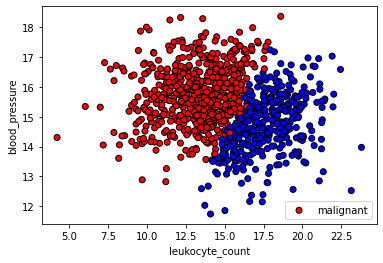

In [7]:
# Plot DataFrame

colors = {'benign' : 'blue', 'malignant' : 'red'}
plt.scatter(data['leukocyte_count'], data['blood_pressure'], c = [colors[item] for item in y], edgecolors = 'k')
plt.xlabel('leukocyte_count')
plt.ylabel('blood_pressure')
plt.legend(['malignant', 'benign'], loc = 'lower right')
plt.show()

# Split data

In [8]:
from sklearn.model_selection import train_test_split

def split(X, y, val_size, test_size, shuffle):
    'Função responsável por split do dataframe de maneira randomica em: treino, validação e teste'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, shuffle = shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, stratify = y_train, shuffle = shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

X_train, X_val, X_test, y_train, y_val, y_test = split(X, y, VAL_SIZE, TEST_SIZE, SHUFFLE)

print(f'Numero de amostras no dataframe :\n')
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}, y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')

print(f'Amostra : {X_train[0]} --> {y_train[0]}')

Numero de amostras no dataframe :

X_train : (722, 2), y_train : (722,)
X_val : (128, 2), y_val : (128,)
X_test : (150, 2), y_test : (150,)
Amostra : [13.9834559  16.85570849] --> malignant


In [9]:
import collections
# Existem duas maneiras de obter a distribuição de rótulos
# 1]
print(data['tumor_class'].value_counts(),'\n')
# 2
class_counts = dict(collections.Counter(y))
print(f'Classes : {class_counts}')

malignant    611
benign       389
Name: tumor_class, dtype: int64 

Classes : {'malignant': 611, 'benign': 389}


In [10]:
# É preciso usar o LabelEncoder para converter os labels em numéricos


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_le = le.fit(y_train)
classes = y_le.classes_

print(f'y_train[0] : {y_train[0]}')
y_train = y_le.transform(y_train)
y_val = y_le.transform(y_val)
y_test = y_le.transform(y_test)
print(f'y_train[0] : {y_train[0]}')

classes1 = collections.Counter(y_train)
class_weights = {_class : 1.0/count for _class, count in classes1.items()}
print (f"Classe counts: {classes1},\nclasse pesos: {class_weights}")

y_train[0] : malignant
y_train[0] : 1
Classe counts: Counter({1: 441, 0: 281}),
classe pesos: {1: 0.0022675736961451248, 0: 0.0035587188612099642}


# Standardize the data

In [11]:
# É preciso padronizar os dados

from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(X_train)

X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

# Check (means should be ~0 and std should be ~1)
print (f"X_train[0]: mean: {np.mean(X_train[:, 0], axis=0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(X_train[:, 1], axis=0):.1f}, std: {np.std(X_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(X_val[:, 0], axis=0):.1f}, std: {np.std(X_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(X_val[:, 1], axis=0):.1f}, std: {np.std(X_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_train[0]: mean: -0.0, std: 1.0
X_train[1]: mean: 0.0, std: 1.0
X_val[0]: mean: 0.0, std: 1.0
X_val[1]: mean: -0.0, std: 1.1
X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: 0.1, std: 1.1


In [12]:
INPUT_DIM = X_train.shape[1]
NUM_CLASSES = len(classes)

In [13]:
import torch.nn.functional as F
from torch import nn

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)
        
    def forward(self, x_in, apply_softmax = False):
        y_pred = self.fc1(x_in)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim = 1)
        return y_pred
    
model = LogisticRegression(input_dim = INPUT_DIM, num_classes = NUM_CLASSES)
print(model.named_parameters)


<bound method Module.named_parameters of LogisticRegression(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


# Loss

In [14]:
loss_fn = nn.CrossEntropyLoss()

In [15]:
# Em nosso caso, também incorporaremos os pesos das classes em nossa função de perda para combater quaisquer desequilíbrios de classe.
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())])
loss_fn = nn.CrossEntropyLoss(weight=weights)

# Metricas

In [16]:
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

# Optimizers

In [17]:
learning_rate = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Treinamento

In [18]:
# Convertendo as amostras em tensores
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [19]:
EPOCHS = 100
for epoch in range(EPOCHS):
    
    y_pred = model(X_train)
    
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%10==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoca: {epoch} | loss: {loss:.2f}, Acc: {accuracy:.1f}")

Epoca: 0 | loss: 0.65, Acc: 53.9
Epoca: 10 | loss: 0.23, Acc: 92.7
Epoca: 20 | loss: 0.14, Acc: 97.9
Epoca: 30 | loss: 0.11, Acc: 97.9
Epoca: 40 | loss: 0.10, Acc: 97.8
Epoca: 50 | loss: 0.09, Acc: 97.9
Epoca: 60 | loss: 0.08, Acc: 98.1
Epoca: 70 | loss: 0.08, Acc: 98.1
Epoca: 80 | loss: 0.07, Acc: 98.1
Epoca: 90 | loss: 0.07, Acc: 98.1


# Avaliação

In [20]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    

In [21]:
# Predição

pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"Prob. da amostra: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"Classe da amostra: {pred_test[0]}")

Prob. da amostra: tensor([0.1167, 0.8833], grad_fn=<SelectBackward>)
Classe da amostra: 1


In [22]:
# Acc
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 1.00


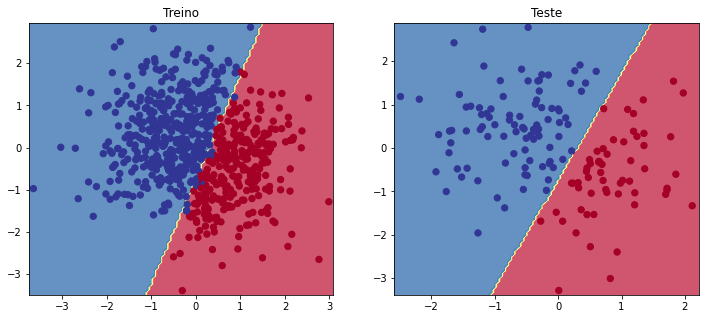

In [23]:
# Visualizando as classes
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Treino")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Teste")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

# Inferencia

In [24]:
X_infer = pd.DataFrame([{'leukocyte_count': 50, 'blood_pressure': 24}])
X_infer.head()

,leukocyte_count,blood_pressure
0,50,24


In [25]:
# Standardize
X_infer = ss.transform(X_infer)
print (X_infer)

[[11.86269951  8.16123429]]


In [26]:
# Predicao
y_infer = model(torch.Tensor(X_infer), apply_softmax=True)
prob, _class = y_infer.max(dim=1)
print (f"A probabilidade de você ter um {classes[_class.detach().numpy()[0]]} tumor é {prob.detach().numpy()[0]*100.0:.0f}%")

A probabilidade de você ter um benign tumor é 100%
